# Creating warm start forcing data

We want to add or replace soil data in the forcing data files. We show an example here, where we take the soil data from the output file of a remo run and add this to the forcing file of another run for use as initial lateral boundary conditions. 

In [41]:
import xarray as xr
from pyremo import remo_ds as rds
from pyremo import codes as rc

afile = xr.open_dataset("/work/ch0636/g300046/forcing-data/ERA5/EUR-11/xa/a056526a2002010100.nc")
tfile = rds.open_remo_dataset("/work/ch0636/g300046/forcing-data/ERA5/EUR-11/xa/e056524t2002010100", update_meta=True)

In [42]:
tfile

<xarray.Dataset>
Dimensions:       (lev: 27, lev_2: 27, nhyi: 28, nhym: 27, rlat: 433, rlat_2: 433, rlon: 433, rlon_2: 433, time: 1)
Coordinates:
  * time          (time) float64 2.002e+07
  * rlon          (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat          (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
  * rlon_2        (rlon_2) float64 -28.87 -28.76 -28.65 ... 18.43 18.54 18.65
  * rlat_2        (rlat_2) float64 -23.87 -23.76 -23.65 ... 23.43 23.54 23.65
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 23.0 24.0 25.0 26.0 27.0
  * lev_2         (lev_2) float64 1.0 2.0 3.0 4.0 5.0 ... 24.0 25.0 26.0 27.0
Dimensions without coordinates: nhyi, nhym
Data variables: (12/38)
    rotated_pole  int32 ...
    hyai          (nhyi) float64 ...
    hybi          (nhyi) float64 ...
    hyam          (nhym) float64 ...
    hybm          (nhym) float64 ...
    FIB           (time, rlat, rlon) float32 ...
    ...            ...
    TSI           (time, rlat, rlon) float32 ...
    SEAICE        (time, rlat, rlon) float32 ...
    SICED         (time, rlat, rlon) float32 ...
    PHI           (time, rlat, rlon) float32 ...
    RLA           (time, rlat, rlon) float32 ...
    QI            (time, lev, rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Jun 16 14:49:09 2021: cdo -O -f nc -copy /work/ch0636/g...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

The output dataset (`tfile`) contains the spin up soil data. This could also come from another point in time of the same run or another run. The soil is defined by a number of codes or variable names:

In [43]:
soil_codes = [54,55,56,206,207,208,209,232,170,183,84,140,194,141]
soil_vars = [rc.get_dict(c)['variable'] for c in soil_codes]
soil_vars

['TSL',
 'TSW',
 'TSI',
 'TSN',
 'TD3',
 'TD4',
 'TD5',
 'GLAC',
 'TD',
 'TDCL',
 'QDBL',
 'WS',
 'WL',
 'SN']

Now we copy and replace the data from the output file (`tfile`) in the forcing file (`afile`).

In [44]:
for var in soil_vars:
    afile[var] = tfile[var]

In [45]:
afile

<xarray.Dataset>
Dimensions:                     (lev: 27, nhyi: 28, rlat: 433, rlon: 433, time: 1)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
    lon                         (rlat, rlon) float64 ...
    lat                         (rlat, rlon) float64 ...
  * time                        (time) float64 2.002e+07
Dimensions without coordinates: lev, nhyi
Data variables: (12/24)
    rotated_latitude_longitude  int32 ...
    hyai                        (nhyi) float64 ...
    hybi                        (nhyi) float64 ...
    T                           (time, lev, rlat, rlon) float32 ...
    PS                          (time, rlat, rlon) float32 ...
    U                           (time, lev, rlat, rlon) float32 ...
    ...                          ...
    TD                          (time, rlat, rlon) float32 ...
    TDCL                        (time, rlat, rlon) float32 ...
    WS                          (time, rlat, rlon) float32 ...
    WL                          (time, rlat, rlon) float32 ...
    SN                          (time, rlat, rlon) float32 ...
    GLAC                        (time, rlat, rlon) float32 ...
Attributes:
    driving_model_CDI:          Climate Data Interface version 1.9.7.1 (http:...
    driving_model_Conventions:  CF-1.6
    driving_model_history:      Fri Jun 04 14:56:03 2021: cdo -O -setname,ta ...
    driving_model_institution:  European Centre for Medium-Range Weather Fore...
    driving_model_CDO:          Climate Data Operators version 1.9.7.1 (http:...

Now, we can write that data back to netCDF format.

In [57]:
afile.to_netcdf("/work/ch0636/g300046/forcing-data/ERA5/EUR-11/xa/a056526a2002010100_warm_soil.nc")

We should check the data with a simple plot, we will look at the temperatures here.

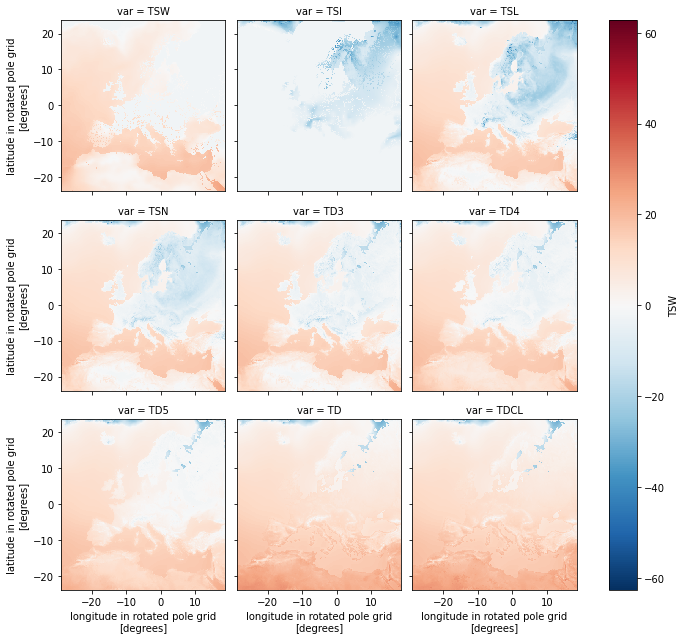

In [6]:
def vars_by_units(ds, units):
    temps = [var for var in ds if ds[var].attrs.get('units', None) == units]
    dim=xr.DataArray(data=temps, dims='var', name='var')
    return xr.concat([ds[var]-273.5 for var in temps], dim=dim)

vars_by_units(afile, 'K').plot(col='var', col_wrap=3)

## Adding static fields to the forcing file

In [46]:
from pyremo import data as rd
surflib = rd.surflib('EUR-11', update_meta=False)
surflib

<xarray.Dataset>
Dimensions:       (rlat: 433, rlon: 433)
Coordinates:
  * rlon          (rlon) float64 -28.93 -28.82 -28.71 ... 18.38 18.48 18.59
  * rlat          (rlat) float64 -23.93 -23.82 -23.71 ... 23.38 23.48 23.59
Data variables: (12/14)
    rotated_pole  int32 ...
    var129        (rlat, rlon) float32 ...
    var172        (rlat, rlon) float32 ...
    var173        (rlat, rlon) float32 ...
    var174        (rlat, rlon) float32 ...
    var198        (rlat, rlon) float32 ...
    ...            ...
    var212        (rlat, rlon) float32 ...
    var226        (rlat, rlon) float32 ...
    var229        (rlat, rlon) float32 ...
    var272        (rlat, rlon) float32 ...
    var273        (rlat, rlon) float32 ...
    var274        (rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 01 12:03:07 2020: cdo -f nc copy lib_EUR-11_frac li...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [47]:
surflib['rlon'] = afile.rlon
surflib['rlat'] = afile.rlat

In [48]:
afile = xr.merge([afile, surflib])

In [49]:
afile.to_netcdf("/work/ch0636/g300046/forcing-data/ERA5/EUR-11/xa/a056526a2002010100_warm_soil.nc")